In [ ]:
%pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pip install torch
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

Mounted at /content/drive


In [ ]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


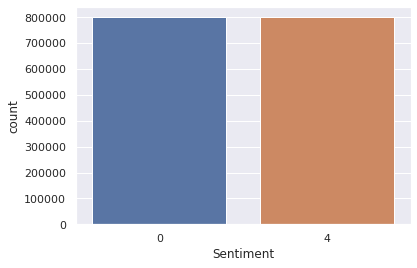

In [ ]:
sns.countplot(df.Sentiment)

In [ ]:
df['Sentiment'] = df.Sentiment.replace(4,1)

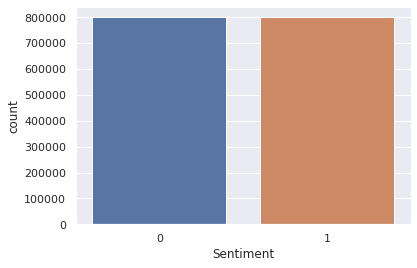

In [ ]:
sns.countplot(df.Sentiment)

In [ ]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

In [ ]:
df['Tweet'] = df.Tweet.apply(process_text)

In [ ]:
df.head()

,Sentiment,Tweet
0,0,"entity - awww, that's a bummer. you shoulda ..."
1,0,is upset that he can't update his facebook by ...
2,0,entity i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire
4,0,"entity no, it's not behaving at all. i'm mad. ..."


In [ ]:
labels = df.Sentiment.values
text = df.Tweet.values

In [ ]:
from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [ ]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  1280000
Validation Size -  320000


In [ ]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 32)

In [ ]:
len(train_dl),len(val_dl)

(40000, 10000)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [ ]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [ ]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [ ]:
import torch.cuda.amp as amp


In [ ]:
from torch.cuda import amp


In [ ]:
import torch
import torch.nn as nn
from torch.cuda import amp
from tqdm.notebook import tqdm
import torch.optim as optim

torch.cuda.empty_cache()

# Define the gradient scaler for mixed precision training
scaler = amp.GradScaler()

# Move the model to the GPU
model.to(device)

# Define other parameters
accumulation_steps = 4  # Accumulate gradients over 4 batches before optimization
epochs = 1  # Number of epochs
from torch.cuda.amp import autocast, GradScaler

# Enable mixed precision training
scaler = GradScaler()

# Training loop
for epoch in tqdm(range(1, epochs+1)):

    model.train()
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc=f'Epoch {epoch}', leave=False, disable=False)

    for i, batch in enumerate(progress_bar):
        model.zero_grad()

        # Move batch to GPU
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        # Forward pass with mixed precision training
        with autocast():
            outputs = model(**inputs)
            loss = outputs.loss

        # Backward pass
        scaler.scale(loss).backward()

        # Accumulate gradients
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_train_total += loss.item()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # Print training loss
    loss_train_avg = loss_train_total/len(train_dl)
    tqdm.write(f'\nEpoch {epoch}')
    tqdm.write(f'Training loss: {loss_train_avg}')

    # Evaluate validation loss and accuracy
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3563905211903155
Validation loss: 0.3292117874909192
Accuracy: 0.856521875


In [ ]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the directory path in your Google Drive where you want to save the model
output_dir = '/content/drive/My Drive/BERT_Model/'

# Create the directory if it doesn't exist
!mkdir -p "$output_dir"

# Save the BERT model and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/My Drive/BERT_Model/tokenizer_config.json',
 '/content/drive/My Drive/BERT_Model/special_tokens_map.json',
 '/content/drive/My Drive/BERT_Model/vocab.txt',
 '/content/drive/My Drive/BERT_Model/added_tokens.json')

In [ ]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [ ]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [ ]:
ans = Sentiment('i don t feel right today')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Negative


TEST EVALUATION:

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/BERT_Model/').to(device)

# Set the model to evaluation mode
model.eval()

# Define the evaluation function
def evaluate(model, test_loader):
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)

            predictions.extend(predicted_labels.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())

    return predictions, true_labels

# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index for both train and test sets
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Define the test dataset and DataLoader
test_data = test_data.sample(frac=0.2, random_state=42)  # Select 20% of the test data randomly
test_data.reset_index(drop=True, inplace=True)

test_input_ids = []
test_attention_masks = []

for i in test_data['Tweet']:
    encoded_data = tokenizer.encode_plus(
        i,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    test_input_ids.append(encoded_data['input_ids'])
    test_attention_masks.append(encoded_data['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_data['Sentiment'])

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, sampler=SequentialSampler(test_dataset))

# Call the evaluate function
predictions, true_labels = evaluate(model, test_loader)

# Print the classification report
print(classification_report(true_labels, predictions))

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(true_labels, predictions)

# Print the confusion matrix
print('Confusion Matrix:')
print(cnf_matrix)

# Plot the confusion matrix
categories = ['Negative', 'Positive']
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cnf_matrix.flatten() / np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cnf_matrix, annot=labels, cmap='Blues', fmt='',
            xticklabels=categories, yticklabels=categories)

plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
plt.show()
